In [119]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import emcee
import exocartographer.gp_map as gm
import healpy
import plotutils.autocorr as ac
import plotutils.plotutils as pu
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [3]:
seaborn.set_style('ticks')

## Try Sampling From the Ylm GP

Here we have a map that has a 20% variance ($\sigma = 0.2$ in $\log$-space), only 1% white noise, with ``nside = 4``.  The angular scale is 
$$
\lambda = \frac{\pi}{2} = 90^\circ
$$

In [134]:
nside = 4
mu = 0.0
sigma = 0.2
wn_frac = 0.01
lam = np.pi/2

In [135]:
logmap = gm.draw_map_cl(4, 0.0, 0.2, 0.01, np.pi/2)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


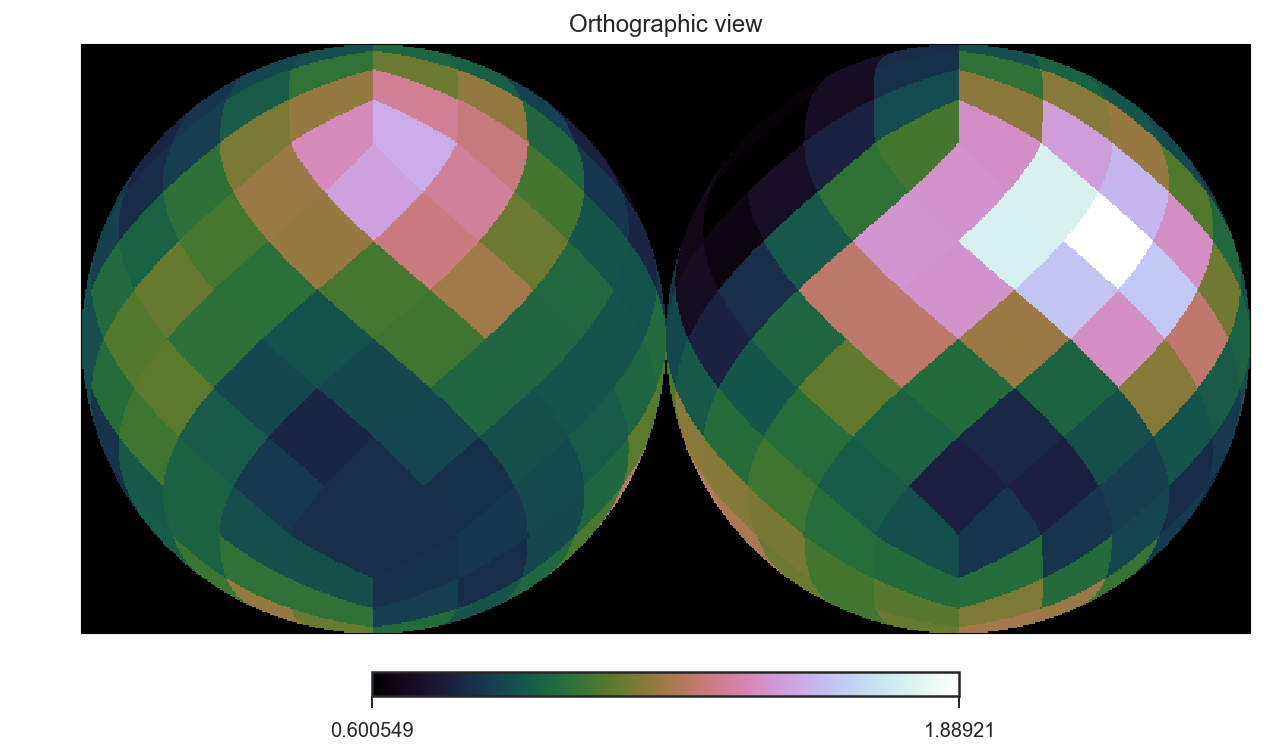

In [136]:
healpy.orthview(exp(logmap), cmap='cubehelix')

Let's try to sample from this map prior; if we successfully do so, each draw will correspond to a map like the above.  

In [137]:
def logpost(logmap):
    return gm.map_logprior_cl(logmap, mu, sigma, wn_frac, lam)

In [138]:
nwalkers = 512
sampler = emcee.EnsembleSampler(nwalkers, healpy.nside2npix(nside), logpost)

Initial condition (cleverly drawn from the prior, so we don't have any burnin):

In [139]:
result = [array([gm.draw_map_cl(nside, mu, sigma, wn_frac, lam) for i in range(nwalkers)])]

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

I just keep running the cells below until I see good ACL estimates for each map pixel.  Usually I run for 1000, 2000, 4000, ... steps until I get there just so I don't have to re-start the runs all the time.

In [207]:
result = sampler.run_mcmc(result[0], 16000, thin=10)

0.0957657618432


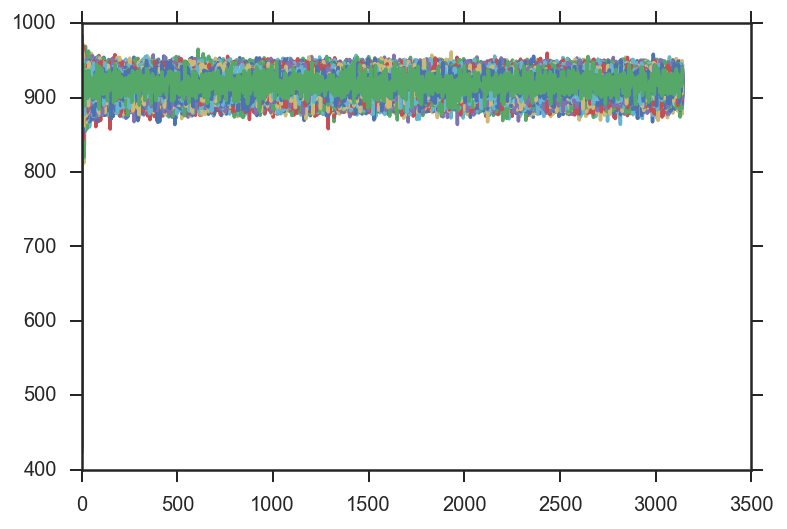

In [208]:
plot(sampler.lnprobability.T)
print mean(sampler.acceptance_fraction)

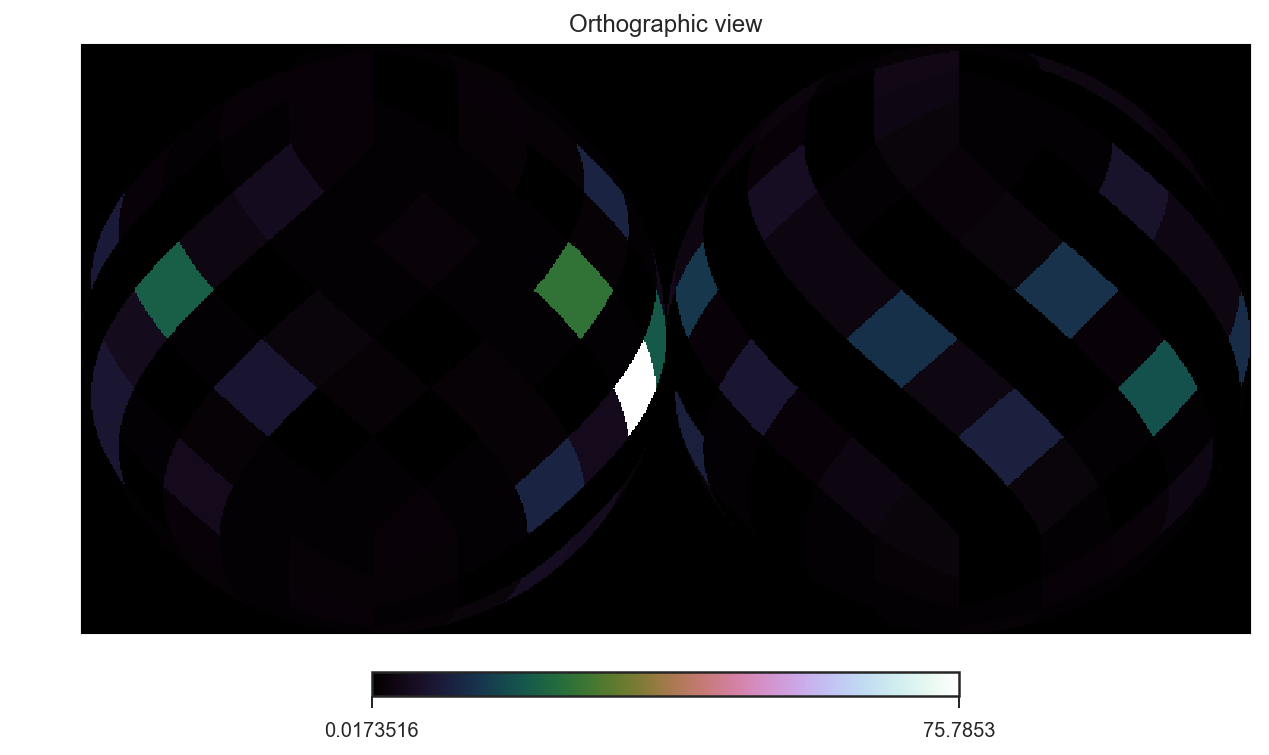

In [209]:
healpy.orthview(exp(result[0][1,:]), cmap='cubehelix')

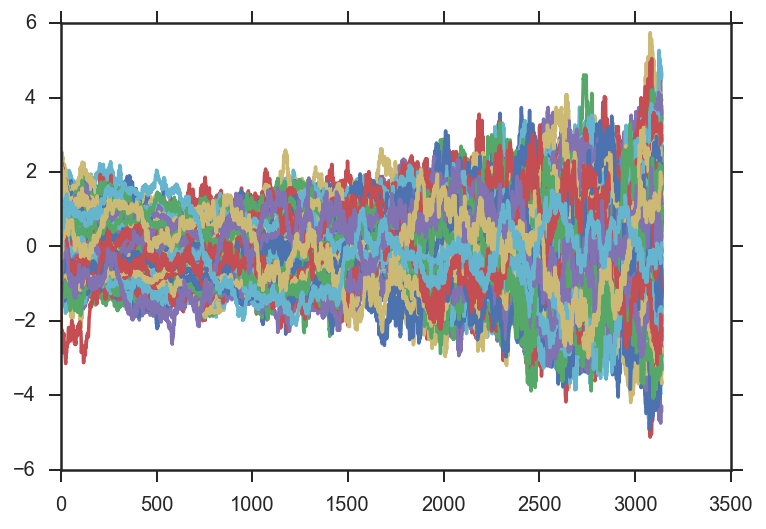

In [210]:
pu.plot_emcee_chains_one_fig(sampler.chain)

In [211]:
ac.emcee_chain_autocorrelation_lengths(sampler.chain)

array([ 208.33031003,  175.24406214,  189.96001341,  179.92738282,
        193.97988045,  183.63301969,  115.03966386,           nan,
                 nan,           nan,           nan,  252.92487099,
        180.18983344,  183.28354933,  199.03361591,           nan,
                 nan,           nan,  207.41279553,           nan,
        102.74726003,  102.05130827,  210.13069838,  184.43539804,
        176.81135564,  165.907905  ,  103.21874158,  203.02232472,
                 nan,  172.18700517,           nan,           nan,
        217.95611946,           nan,   82.45871276,           nan,
         94.97834334,           nan,  215.34682495,  211.42470675,
                 nan,           nan,  204.69236997,   96.67874899,
        247.35170313,           nan,           nan,  175.80869452,
        107.31691906,           nan,  112.0714843 ,           nan,
         98.24204317,  166.3630718 ,           nan,  255.02364794,
        200.45617603,  140.89975332,  101.59874981,  202.37721

Let's check the mean angular power spectrum of the resulting maps.  This looks promising:

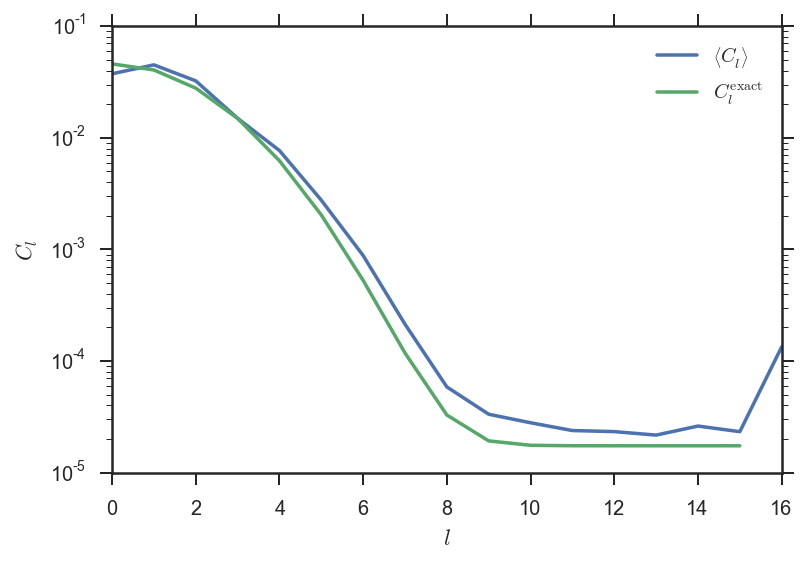

In [219]:
mean_cl = mean(array([healpy.anafast(r, lmax=4*nside) for r in result[0]]), axis=0)
plot(mean_cl, label=r'$\left\langle C_l \right\rangle$')
plot(sigma*sigma*gm.exp_cov_cl(nside, wn_frac, lam), label=r'$C_l^\mathrm{exact}$')
yscale('log')
legend(loc='upper right')
xlabel(r'$l$')
ylabel(r'$C_l$')

...but this does not.  Since the Ylm's are not orthonormal, we have degenerate modes that we do not constrain with the prior:

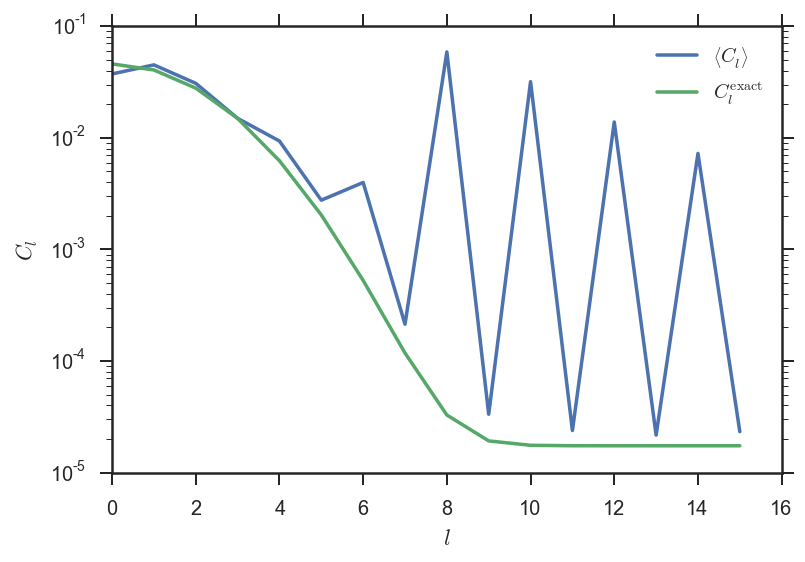

In [220]:
mean_cl = mean(array([healpy.anafast(r, lmax=4*nside-1) for r in result[0]]), axis=0)
plot(mean_cl, label=r'$\left\langle C_l \right\rangle$')
plot(sigma*sigma*gm.exp_cov_cl(nside, wn_frac, lam), label=r'$C_l^\mathrm{exact}$')
yscale('log')
legend(loc='upper right')
xlabel(r'$l$')
ylabel(r'$C_l$')